In [48]:
import pandas as pd
import numpy as np
import psycopg2
import pickle
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [37]:
def pg_hook():
    return psycopg2.connect(dbname="mydb", user="myuser", password="mypassword", host='localhost', port=5439)
conn = pg_hook()
conn.autocommit = True


In [151]:
q_pg = """
SELECT * FROM mlm.ytrue
INNER JOIN mlm.scores USING(puid);
"""
df = pd.read_sql(q_pg, conn)
df.set_index('puid', drop=True, inplace=True)
y_true = df['y_true'].copy()
df.drop(['create_ts', 'update_ts', 
        'y_true'], axis=1, inplace=True)
distance_ths = 2000
df['geo_similarity'] = df['geo_distance'].where(~df['geo_distance'].isnull(),distance_ths).apply(lambda r:max( (distance_ths-r)/distance_ths , 0))

In [152]:
X= df[['firstnames_tfidf', 'surname_tfidf', 'locality_tfidf',
       'postalcodelong_tfidf', 'route_tfidf', 'title_tfidf',
       'firstnames_levenshtein', 'surname_levenshtein', 'route_levenshtein',
       'locality_levenshtein', 'postalcodelong_levenshtein',
       'firstnames_trg_metaphone', 'surname_trg_metaphone',
       'locality_trg_metaphone', 'route_trg_metaphone',
       'phone_exact', 'email_exact', 'ni_number_exact', 'geo_similarity']].fillna(0)

In [95]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score,\
accuracy_score, precision_score, confusion_matrix

In [124]:
def grid_search_wrapper(X_train, y_train, X_test, y_test, clf, param_grid, refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of model optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    results = pd.DataFrame(grid_search.cv_results_)
    results = results.sort_values(by=f'mean_test_{refit_score}', ascending=False)
    return grid_search, results

In [155]:
clf_gb = GradientBoostingClassifier()

param_grid_gb = {
    'min_samples_split': [3, 4,5, 8], 
    'n_estimators' : [50, 75, 100],
    'max_depth': [8, 10, 12, 15],
    'max_features': [3, 4, 5, 7]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}


In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y_true)
grid_gb, results_gb = grid_search_wrapper(X_train, y_train, X_test, y_test, clf_gb, param_grid_gb, 'recall_score')
results_gb[['mean_test_precision_score','mean_test_recall_score','mean_test_accuracy_score']].head(4)

Best params for recall_score
{'max_depth': 8, 'max_features': 3, 'min_samples_split': 3, 'n_estimators': 75}

Confusion matrix of model optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       134         2
pos         2        57


,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score
145,0.984444,0.994444,0.993162
16,0.990000,0.994444,0.994886
1,0.990000,0.994444,0.994886
101,0.990000,0.994444,0.994886


In [157]:
best_params = {'max_depth': 8, 'max_features': 3, 'min_samples_split': 3, 'n_estimators': 75}

In [169]:
from sklearn.inspection import permutation_importance
gb = GradientBoostingClassifier(**grid_gb.best_params_)
gb.fit(X_train, y_train)
gb.score(X_test, y_test)
recall_score(y_test, gb.predict(X_test))

0.9830508474576272

In [161]:
with open('/Users/pogier/Documents/63-Elk/dockersetup/shared_volume/ml_models/gradient_boosting.pickle', 'wb') as f1:
    pickle.dump(gb, f1)

In [164]:
import json
with open('/Users/pogier/Documents/63-Elk/dockersetup/shared_volume/ml_models/gradient_boosting.txt', 'w') as f2:
    f2.write(','.join(X.columns))
    f2.write('\n')
    json.dump(grid_gb.best_params_, f2)

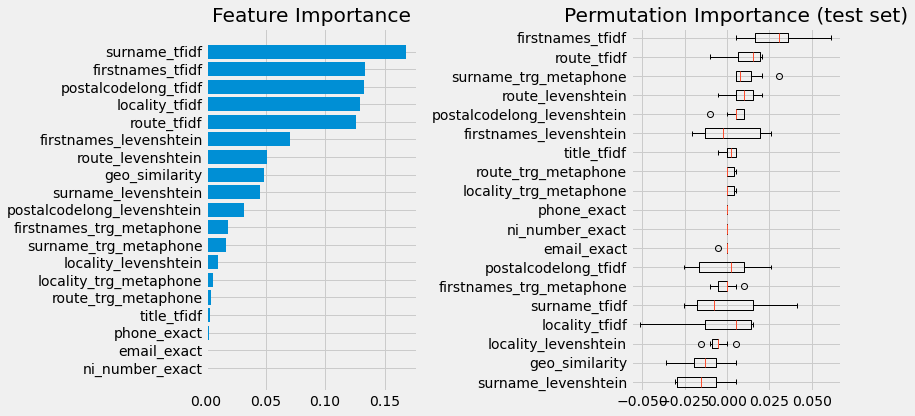

In [147]:
feature_importance = gb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')
fig.tight_layout()
result = permutation_importance(gb, X_test, y_test, n_repeats=10, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## Feature Selection: Reducing the number of columns for faster & More reproducible

In [140]:
Xs = df[['firstnames_tfidf', 'firstnames_levenshtein', 'firstnames_trg_metaphone', 
         'surname_tfidf', 'surname_levenshtein',
         'geo_similarity',  'postalcodelong_tfidf',
          'locality_tfidf',  'route_tfidf']].fillna(0)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, y_true)
clf_gbs = GradientBoostingClassifier()
param_grid_gbs = param_grid_rf = {
    'min_samples_split': [ 5, 7], 
    'n_estimators' : [50, 75, 100],
    'max_depth': [10, 12, 15, 17, 20],
    'max_features': [ 4, 5, 7]
}
grid_gbs, results_gbs = grid_search_wrapper(Xs_train, ys_train, Xs_test, ys_test, clf_gbs, param_grid_gb, 'recall_score')
results_gbs[['mean_test_precision_score','mean_test_recall_score','mean_test_accuracy_score']].head(4)

Best params for recall_score
{'max_depth': 10, 'max_features': 4, 'min_samples_split': 8, 'n_estimators': 75}

Confusion matrix of model optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       128         1
pos         1        65


,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score
33,0.973918,0.977778,0.984629
80,0.978655,0.977778,0.986324
58,0.973918,0.977778,0.984600
10,0.983918,0.977778,0.988048


## Adjusting the thresholds for sending low-confidence matches to TDS

### We are using the full model to make sure not to forget anythin

In [171]:
y_pred = pd.Series(data=grid_gb.predict(X_test), index=X_test.index, name='y_pred')
y_proba = pd.Series(data=grid_gb.predict_proba(X_test)[:,1], index=X_test.index, name='y_proba')
dfp = pd.concat([y_test, y_pred, y_proba], ignore_index=False, axis=1)
fn = dfp.loc[(dfp['y_pred']==0) & (dfp['y_true']==1)].index
fp = dfp.loc[(dfp['y_pred']==1) & (dfp['y_true']==0)].index
print(f"{y_pred.sum()} positive pairs correctly identified out of {len(y_pred)} possible pairs")
print(f"precision_score:{precision_score(y_test, y_pred)}")
print(f"recall_score:{recall_score(y_test, y_pred)}")
print(f"{len(fn)} false negatives :{fn.values}")
print(f"{len(fp)} false postives :{fp.values}")

59 positive pairs correctly identified out of 195 possible pairs
precision_score:0.9661016949152542
recall_score:0.9661016949152542
2 false negatives :['458827-458829' '499080-499081']
2 false postives :['285743-285744' '465053-465054']


### Lower threshold calculation: All pairs above should be considered potential matches
- increases the number of potential matches --> Increase false positives
- Decreases (and ideally eliminate) the matches missed --> Decreases false negatives

In [187]:
dfp.loc[fn]['y_proba'].min()

0.16888766538656114

In [181]:
ths_recall = 0.1
y_trecall = (y_proba>=ths_recall).astype(int)
total_fn = sum(y_test.multiply((~y_trecall.astype(bool)).astype(int)))
total_fp = sum(y_trecall.multiply((~y_test.astype(bool)).astype(int)))
print(f"{total_fp} false positives: precision_score:{precision_score(y_test, y_trecall)}")
print(f"{total_fn} false negatives: recall_score:{recall_score(y_test, y_trecall)}")

2 false positives: precision_score:0.9672131147540983
0 false negatives: recall_score:1.0


### Higher Threshold

In [186]:
dfp.loc[fp]['y_proba'].max()

0.8147697510080769

In [183]:
ths_sure = 0.85
y_tsure = (y_proba>=ths_sure).astype(int)
dfp['trecall']=y_trecall
dfp['tsure']=y_tsure
dfp['decision']=(dfp['trecall']+dfp['tsure']).map({0:'ignore', 1:'TDS', 2:'Sure'})

In [184]:
dfp[['decision', 'y_true']].pivot_table(index='decision', columns=['y_true'], aggfunc=len).fillna(0)

y_true,0,1
decision,,
Sure,0.0,57.0
TDS,2.0,2.0
ignore,134.0,0.0


In [185]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.9661016949152542

#### 